In [36]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 250)

### Hyperpartisan

In [23]:
 # !cd ..;python parse_tb.py

In [24]:
# res_df[(res_df.from_pretrained == 'bert-base-cased') & (res_df.input_seq_len == 818)]

In [ ]:
paths = ['../results/hyp_grid.csv',
         '../results/hyp.csv',
         '../results/hyp_new.csv',
         '../results/results_sbc/hyp_grid.csv'
        ]
         
         

In [ ]:
res_df = pd.concat([pd.read_csv(p) for p in paths])

In [ ]:
res_df_debug = pd.read_csv('../results/debug_hyp.csv')
res_df['sum_loss'] = False
res_df_debug['sum_loss'] = True
res_df = pd.concat((res_df, res_df_debug))
res_df.input_seg_size = res_df.input_seg_size.fillna(512)

In [ ]:
res_df = res_df.drop_duplicates()
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(0)
res_df = res_df[res_df.f1 > 0]

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss']
metric_cols = ['f1', 'best_valid_f1']

group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['f1_std'] = res_df.groupby(gb_cols).std()[['f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'f1':tuple}).f1.apply(lambda x: [round(i,2) for i in x])
# group_df

In [ ]:
# group_df.to_csv('../results/grouped/hyp.csv')

### contract-nli

In [ ]:
paths = [
        '../results/cnli.csv',
        '../results/contract_nli.csv',
         '../results/debug_cnli.csv',
        ]
         

In [ ]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.sum_loss = res_df.sum_loss.fillna(False)
res_df.segment_ordering = res_df.segment_ordering.fillna('regular')
# res_df.padding_side = res_df.padding_side.fillna('left')
res_df.inter_layer_memory = res_df.inter_layer_memory.fillna('False')
res_df.loc[res_df.from_pretrained == 'facebook/bart-base', 'num_steps'] = res_df[res_df.from_pretrained == 'facebook/bart-base'].num_steps.fillna(3000)
res_df = res_df[res_df.num_steps.isin({3000, 5000, 9000, 4500})]
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(0)
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
# res_df = res_df[res_df.best_valid_exact_match > 65]

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler','sum_loss', 'segment_ordering', 'inter_layer_memory']#, 'batch_size']
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

In [252]:
# group_df.to_csv('../results/grouped/cnli_sum_loss.csv')

In [253]:
# gb_cols = gb_cols[:-1]

In [254]:
# gb_df[~gb_df.sum_loss].shape

In [255]:
gb_df = group_df.reset_index()
gb_df_copy = gb_df.copy()
gb_df_copy.sum_loss = ~gb_df_copy.sum_loss

In [256]:
merged = gb_df.merge(gb_df_copy[gb_cols + ['best_valid_exact_match']], on=gb_cols, how='inner', suffixes=('', '_sum_loss'))
merged = merged[~merged.sum_loss]
merged['sum_loss_added'] = merged.best_valid_exact_match_sum_loss - merged.best_valid_exact_match
# merged

In [257]:
merged = merged[merged.num_mem_tokens == 10]

In [258]:
import matplotlib
from matplotlib import pyplot as plt

Text(0, 0.5, 'number of experiments')

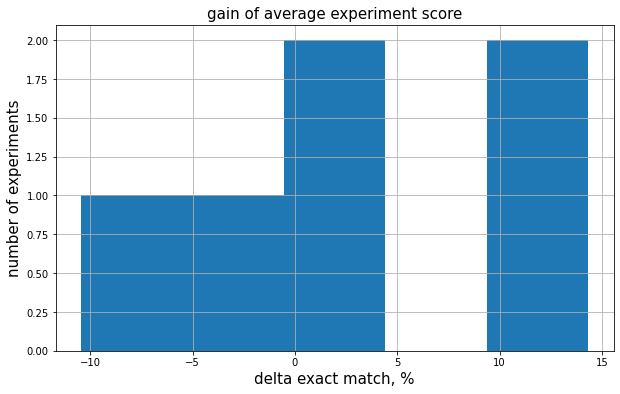

In [259]:

merged.sum_loss_added.hist(bins=5, figsize=(10,6))
plt.title('gain of average experiment score', fontsize=15)
plt.xlabel('delta exact match, %', fontsize=15)
plt.ylabel('number of experiments', fontsize=15)

In [74]:
merged[['from_pretrained','input_seq_len', 'num_mem_tokens',
       'lr', 'lr_scheduler', 'best_valid_exact_match', 'sum_loss_added']].sort_values('sum_loss_added', ascending=False)

,from_pretrained,input_seq_len,num_mem_tokens,lr,lr_scheduler,best_valid_exact_match,sum_loss_added
20,microsoft/deberta-v3-base,1497,10,0.00001,constant_with_warmup,66.730766,6.185900
44,t5-base,1002,10,0.00100,constant_with_warmup,68.930653,3.953133
48,t5-base,1002,10,0.00200,constant_with_warmup,68.689796,3.553772
42,t5-base,1002,10,0.00050,linear,69.556850,3.164616
40,t5-base,1002,10,0.00050,constant_with_warmup,71.820801,1.863767
16,microsoft/deberta-v3-base,998,10,0.00001,constant_with_warmup,73.493591,1.410255
46,t5-base,1002,10,0.00100,linear,72.206203,1.373947
18,microsoft/deberta-v3-base,998,10,0.00001,linear,73.750000,0.543943
6,bert-base-cased,998,10,0.00001,constant_with_warmup,72.211538,0.509982
26,roberta-base,998,10,0.00001,linear,74.006409,0.030201


### qasper

In [454]:
# !cd ..;python parse_tb.py

In [25]:
res_df = pd.read_csv('../results/qasper.csv')


In [26]:
# res_df = res_df[res_df.best_valid_f1 > 6]
res_df = res_df[res_df.num_steps.isin({1600})]

res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df.inter_layer_memory = res_df.inter_layer_memory.fillna(False)
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna(-1)
res_df.sum_loss = res_df.sum_loss.fillna(False)
res_df.segment_ordering = res_df.segment_ordering.fillna('regular')
res_df.padding_side = res_df.padding_side.fillna('left')
res_df.fillna('UNKNOWN', inplace=True)

In [27]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering', 'padding_side', 'inter_layer_memory']
metric_cols = ['best_valid_f1']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_f1']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_f1']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_f1':tuple}).best_valid_f1.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_f1  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering padding_side inter_layer_memory                  
t5-base         256.0          512            10.0          0.00020 linear       True     repeat_first     left         False                   14.770700   
                               768            10.0          0.00020 linear       True     repeat_first     left         False                   15.114600   
                               1024           10.0          0.00020 linear       True     repeat_first     left         False                   14.248900   
                512.0          486            0.0           0.00020 linear       True     regular          left         False                   19.184600   
                                              25.0          0.00020 linear       True     regular          left         False                   16.932600   
                                                                                          repeat_first     left         False                   16.539075   
                               499            0.0           0.00020 linear       True     regular          left         False                   19.231800   
                                              10.0          0.00020 linear       True     regular          left         False                   17.137801   
                                                                                          repeat_first     left         False                   17.265100   
                               512           -1.0           0.00020 linear       False    regular          left         False                   20.372159   
                                              0.0           0.00020 linear       True     regular          left         False                   19.338425   
                               972            25.0          0.00010 linear       True     repeat_first     left         False                   13.446550   
                                                            0.00020 linear       True     regular          left         False                   11.792767   
                                                                                          repeat_first     left         False                   15.455400   
                               1002           0.0           0.00020 linear       True     regular          left         False                   11.295500   
                                              10.0          0.00005 linear       False    regular          left         False                   10.494500   
                                                                                 True     regular          left         False                   10.908867   
                                                                                          repeat_first     left         False                   12.121700   
                                                            0.00010 linear       False    regular          left         False                   10.929900   
                                                                                 True     regular          left         False                   11.165933   
                                                                                          repeat_first     left         False                   13.840866   
                                                            0.00020 linear       False    repeat_first     left         False                   15.143000   
                                                                                 True     regular          left         False                   12.527633   
                                                                                          repeat_first     left         False                   15.748167   
                                                          

### qmsum

In [28]:
res_df = pd.read_csv('../results/qmsum.csv')

In [29]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [30]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_rouge/geometric_mean  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                                    
t5-base         256.0          512           10.0           0.00020 linear       True     repeat_first                            15.118150   
                               768           10.0           0.00020 linear       True     repeat_first                            14.362800   
                               1024          10.0           0.00020 linear       True     repeat_first                            14.139850   
                512.0          486           0.0            0.00020 linear       True     regular                                 16.565500   
                                             25.0           0.00020 linear       True     regular                                 16.238299   
                                                                                          repeat_first                            15.910350   
                               501           0.0            0.00020 linear       True     regular                                 16.854300   
                                             10.0           0.00020 linear       True     regular                                 16.309200   
                                                                                          repeat_first                            15.987501   
                               512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                                 16.604200   
                               958           32.0           0.00020 linear       True     repeat_first                            13.260833   
                               990           16.0           0.00020 linear       True     repeat_first                            14.060675   
                               1002          0.0            0.00020 linear       True     regular                                 12.312900   
                                             10.0           0.00005 linear       False    regular                                 11.114800   
                                                                                 True     repeat_first                            14.327650   
                                                            0.00010 linear       True     bidirectional                           15.288950   
                                                                                          repeat_first                            15.128800   
                                                            0.00020 linear       False    regular                                 12.547350   
                                                                                 True     bidirectional                           15.403150   
                                                                                          regular                                 11.582300   
                                                                                          repeat_first                            15.474175   
                                                            0.00050 linear       True     bidirectional                           15.151300   
                                                                                          repeat_first                            15.268400   
                               1006          8.0            0.00020 linear       True     repeat_first                            14.025825   
                               1014          4.0            0.00020 linear       True     repeat_first                            14.237825   
                               1018          2.0            0.00020 linear       True     repeat_first                            14.456650   
                               1020          1.0            0.00020 linear       True     repeat_first  

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [2]:
# !cd ..;python parse_tb.py

In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              